# Pyfolio Analysis - Complete Tearsheet

This notebook demonstrates how to analyze backtest results using pyfolio.

Pyfolio generates comprehensive "tearsheets" including:
- Returns analysis
- Risk metrics (Sharpe, Sortino, Max Drawdown)
- Rolling statistics
- Drawdown periods
- Position concentration
- Transaction costs

## Setup

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from zipline import run_algorithm
from zipline.api import (
    order_target_percent,
    symbol,
    record,
    schedule_function,
    date_rules,
    time_rules,
)
from zipline.utils.progress import enable_progress_logging

# Import pyfolio
try:
    import pyfolio as pf
    print("✓ Pyfolio imported successfully")
except ImportError:
    print("⚠️  Pyfolio not installed. Install with: pip install pyfolio-reloaded")
    raise

# Enable logging
logging.basicConfig(level=logging.INFO, force=True)

# Suppress matplotlib.category INFO messages (cosmetic warnings from pyfolio)
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

enable_progress_logging(algo_name='Pyfolio-Demo', update_interval=20)

✓ Pyfolio imported successfully


## Example Strategy: Momentum Rotation

Rotates between top 3 momentum stocks from a basket of tech stocks.
Rebalances monthly.

In [3]:
# Universe of stocks to trade
UNIVERSE = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NFLX']
TOP_N = 3  # Hold top 3 momentum stocks
MOMENTUM_WINDOW = 60  # 60-day momentum lookback

def initialize(context):
    """
    Initialize strategy.
    """
    # Create symbols
    context.universe = [symbol(s) for s in UNIVERSE]
    context.top_n = TOP_N
    context.momentum_window = MOMENTUM_WINDOW
    
    # Schedule rebalance at start of month
    schedule_function(
        rebalance,
        date_rules.month_start(),
        time_rules.market_open(hours=1)
    )
    
    logging.info(f"Strategy initialized")
    logging.info(f"  Universe: {len(UNIVERSE)} stocks")
    logging.info(f"  Holding top {TOP_N} momentum stocks")
    logging.info(f"  Rebalancing: Monthly")

def rebalance(context, data):
    """
    Monthly rebalance to top momentum stocks.
    """
    # Filter for tradeable stocks only
    tradeable_universe = [stock for stock in context.universe if data.can_trade(stock)]
    
    if len(tradeable_universe) == 0:
        logging.warning("No tradeable stocks in universe")
        return
    
    # Get price history for tradeable stocks
    prices = data.history(
        tradeable_universe,
        'close',
        context.momentum_window + 1,
        '1d'
    )
    
    # Calculate momentum (% change over period)
    momentum = (prices.iloc[-1] / prices.iloc[0]) - 1
    
    # Sort by momentum and get top N (or fewer if not enough tradeable stocks)
    top_n = min(context.top_n, len(tradeable_universe))
    top_stocks = momentum.nlargest(top_n).index
    
    # Equal weight among top stocks
    target_weight = 1.0 / len(top_stocks)
    
    # Rebalance portfolio (only trade tradeable stocks)
    for stock in context.universe:
        if not data.can_trade(stock):
            continue  # Skip untradeable stocks
        
        if stock in top_stocks:
            order_target_percent(stock, target_weight)
        else:
            order_target_percent(stock, 0.0)
    
    # Log current holdings
    holdings = [s.symbol for s in top_stocks]
    logging.info(f"Rebalanced to: {', '.join(holdings)}")

def handle_data(context, data):
    """
    Record daily metrics.
    """
    record(
        portfolio_value=context.portfolio.portfolio_value,
        cash=context.portfolio.cash,
        leverage=context.account.leverage,
    )

## Run Backtest

In [4]:
# Run backtest
results = run_algorithm(
    start=pd.Timestamp('2019-01-01'),
    end=pd.Timestamp('2023-12-31'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=100000,
    data_frequency='daily',
    bundle='sharadar',
)

print(f"\n✓ Backtest complete!")
print(f"  Start: {results.index[0].date()}")
print(f"  End: {results.index[-1].date()}")
print(f"  Days: {len(results)}")

⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharadar-tech, sharadar-sp500, sharadar-all

Use 'zipline bundles' to see which bundles have been ingested.
2025-11-18 07:39:09,131 INFO zipline.progress: [Pyfolio-Demo] Backtest initialized: 2019-01-02 to 2023-12-29 (1258 trading days)
2025-11-18 07:39:09,131 INFO zipline.progress: [Pyfolio-Demo] Progress      Pct    Date             Cum Returns        Sharpe      Max DD             Cum PNL


INFO:root:Strategy initialized
INFO:root:  Universe: 8 stocks
INFO:root:  Holding top 3 momentum stocks
INFO:root:  Rebalancing: Monthly
INFO:root:Rebalanced to: TSLA, MSFT, GOOGL


2025-11-18 07:39:09,779 INFO zipline.progress: [Pyfolio-Demo] ----------      1%  2019-01-30              6%          2.56         -7%               $6.1K


INFO:root:Rebalanced to: META, NFLX, GOOGL


2025-11-18 07:39:09,846 INFO zipline.progress: [Pyfolio-Demo] ----------      3%  2019-02-28              6%          1.66         -7%               $6.2K


INFO:root:Rebalanced to: NFLX, META, GOOGL


2025-11-18 07:39:09,911 INFO zipline.progress: [Pyfolio-Demo] ----------      4%  2019-03-28              8%          1.52         -7%               $8.1K


INFO:root:Rebalanced to: NVDA, NFLX, AAPL


2025-11-18 07:39:09,987 INFO zipline.progress: [Pyfolio-Demo] ----------      6%  2019-04-26             14%          1.99         -7%              $14.0K


INFO:root:Rebalanced to: AAPL, MSFT, NVDA


2025-11-18 07:39:10,053 INFO zipline.progress: [Pyfolio-Demo] ----------      7%  2019-05-24              3%          0.43        -13%               $2.9K


INFO:root:Rebalanced to: MSFT, AMZN, AAPL


2025-11-18 07:39:10,128 INFO zipline.progress: [Pyfolio-Demo] ----------      9%  2019-06-24             13%          1.19        -17%              $12.7K


INFO:root:Rebalanced to: MSFT, META, AMZN


2025-11-18 07:39:10,200 INFO zipline.progress: [Pyfolio-Demo] █---------     11%  2019-07-23             17%          1.37        -17%              $16.9K


INFO:root:Rebalanced to: MSFT, AAPL, GOOGL


2025-11-18 07:39:10,275 INFO zipline.progress: [Pyfolio-Demo] █---------     12%  2019-08-20             11%          0.84        -17%              $11.3K


INFO:root:Rebalanced to: NVDA, TSLA, GOOGL


2025-11-18 07:39:10,343 INFO zipline.progress: [Pyfolio-Demo] █---------     14%  2019-09-18             19%          1.15        -17%              $18.8K


INFO:root:Rebalanced to: AAPL, NVDA, GOOGL


2025-11-18 07:39:10,414 INFO zipline.progress: [Pyfolio-Demo] █---------     15%  2019-10-16             25%          1.31        -17%              $25.0K


INFO:root:Rebalanced to: TSLA, NVDA, AAPL


2025-11-18 07:39:10,481 INFO zipline.progress: [Pyfolio-Demo] █---------     17%  2019-11-13             39%          1.75        -17%              $39.0K


INFO:root:Rebalanced to: TSLA, AAPL, NVDA


2025-11-18 07:39:10,552 INFO zipline.progress: [Pyfolio-Demo] █---------     19%  2019-12-12             45%          1.85        -17%              $45.5K


INFO:root:Rebalanced to: TSLA, AAPL, NVDA


2025-11-18 07:39:10,623 INFO zipline.progress: [Pyfolio-Demo] ██--------     20%  2020-01-13             82%          2.63        -17%              $81.6K


INFO:root:Rebalanced to: TSLA, NFLX, MSFT


2025-11-18 07:39:10,699 INFO zipline.progress: [Pyfolio-Demo] ██--------     22%  2020-02-11            119%          2.82        -17%             $119.1K


INFO:root:Rebalanced to: TSLA, NVDA, NFLX


2025-11-18 07:39:10,764 INFO zipline.progress: [Pyfolio-Demo] ██--------     23%  2020-03-11             89%          1.91        -21%              $88.5K


INFO:root:Rebalanced to: NFLX, TSLA, NVDA


2025-11-18 07:39:10,833 INFO zipline.progress: [Pyfolio-Demo] ██--------     25%  2020-04-08             92%          1.52        -39%              $91.8K


INFO:root:Rebalanced to: NVDA, NFLX, AMZN


2025-11-18 07:39:10,901 INFO zipline.progress: [Pyfolio-Demo] ██--------     27%  2020-05-07            139%          1.82        -39%             $139.3K


INFO:root:Rebalanced to: NVDA, AMZN, META


2025-11-18 07:39:10,984 INFO zipline.progress: [Pyfolio-Demo] ██--------     28%  2020-06-05            154%          1.87        -39%             $154.1K


INFO:root:Rebalanced to: TSLA, AMZN, META


2025-11-18 07:39:11,054 INFO zipline.progress: [Pyfolio-Demo] ███-------     30%  2020-07-06            197%          2.03        -39%             $196.9K


INFO:root:Rebalanced to: TSLA, NVDA, AAPL


2025-11-18 07:39:11,120 INFO zipline.progress: [Pyfolio-Demo] ███-------     31%  2020-08-03            212%          2.02        -39%             $212.4K
2025-11-18 07:39:11,188 INFO zipline.progress: [Pyfolio-Demo] ███-------     33%  2020-08-31            322%          2.37        -39%             $321.9K


INFO:root:Rebalanced to: TSLA, AAPL, NVDA


2025-11-18 07:39:11,261 INFO zipline.progress: [Pyfolio-Demo] ███-------     34%  2020-09-29            277%          2.03        -39%             $277.5K


INFO:root:Rebalanced to: TSLA, NVDA, AAPL


2025-11-18 07:39:11,333 INFO zipline.progress: [Pyfolio-Demo] ███-------     36%  2020-10-27            284%          1.99        -39%             $283.5K


INFO:root:Rebalanced to: TSLA, NVDA, GOOGL


2025-11-18 07:39:11,405 INFO zipline.progress: [Pyfolio-Demo] ███-------     38%  2020-11-24            320%          2.03        -39%             $320.2K


INFO:root:Rebalanced to: TSLA, GOOGL, NVDA


2025-11-18 07:39:11,477 INFO zipline.progress: [Pyfolio-Demo] ███-------     39%  2020-12-23            340%          2.03        -39%             $339.8K


INFO:root:Rebalanced to: TSLA, GOOGL, AAPL


2025-11-18 07:39:11,550 INFO zipline.progress: [Pyfolio-Demo] ████------     41%  2021-01-25            426%          2.19        -39%             $425.7K


INFO:root:Rebalanced to: TSLA, AAPL, MSFT


2025-11-18 07:39:11,624 INFO zipline.progress: [Pyfolio-Demo] ████------     42%  2021-02-23            366%          1.99        -39%             $366.3K


INFO:root:Rebalanced to: TSLA, GOOGL, MSFT


2025-11-18 07:39:11,700 INFO zipline.progress: [Pyfolio-Demo] ████------     44%  2021-03-23            358%          1.90        -39%             $358.5K


INFO:root:Rebalanced to: GOOGL, MSFT, META


2025-11-18 07:39:11,771 INFO zipline.progress: [Pyfolio-Demo] ████------     46%  2021-04-21            394%          1.94        -39%             $393.9K


INFO:root:Rebalanced to: META, GOOGL, NVDA


2025-11-18 07:39:11,846 INFO zipline.progress: [Pyfolio-Demo] ████------     47%  2021-05-19            388%          1.88        -39%             $388.1K


INFO:root:Rebalanced to: NVDA, META, GOOGL


2025-11-18 07:39:11,918 INFO zipline.progress: [Pyfolio-Demo] ████------     49%  2021-06-17            463%          1.99        -39%             $463.1K


INFO:root:Rebalanced to: NVDA, META, GOOGL


2025-11-18 07:39:11,987 INFO zipline.progress: [Pyfolio-Demo] █████-----     50%  2021-07-16            470%          1.97        -39%             $470.5K


INFO:root:Rebalanced to: NVDA, GOOGL, MSFT


2025-11-18 07:39:12,059 INFO zipline.progress: [Pyfolio-Demo] █████-----     52%  2021-08-13            517%          2.01        -39%             $516.8K


INFO:root:Rebalanced to: NVDA, TSLA, GOOGL


2025-11-18 07:39:12,130 INFO zipline.progress: [Pyfolio-Demo] █████-----     54%  2021-09-13            553%          2.03        -39%             $553.1K


INFO:root:Rebalanced to: TSLA, NFLX, GOOGL


2025-11-18 07:39:12,208 INFO zipline.progress: [Pyfolio-Demo] █████-----     55%  2021-10-11            547%          1.99        -39%             $547.0K


INFO:root:Rebalanced to: TSLA, NFLX, NVDA


2025-11-18 07:39:12,286 INFO zipline.progress: [Pyfolio-Demo] █████-----     57%  2021-11-08            712%          2.16        -39%             $711.8K


INFO:root:Rebalanced to: TSLA, NVDA, MSFT


2025-11-18 07:39:12,364 INFO zipline.progress: [Pyfolio-Demo] █████-----     58%  2021-12-07            693%          2.08        -39%             $693.5K


INFO:root:Rebalanced to: TSLA, NVDA, AAPL


2025-11-18 07:39:12,437 INFO zipline.progress: [Pyfolio-Demo] ██████----     60%  2022-01-05            650%          1.97        -39%             $649.7K


INFO:root:Rebalanced to: AAPL, META, GOOGL


2025-11-18 07:39:12,513 INFO zipline.progress: [Pyfolio-Demo] ██████----     62%  2022-02-03            515%          1.73        -39%             $515.1K


INFO:root:Rebalanced to: AAPL, GOOGL, MSFT


2025-11-18 07:39:12,588 INFO zipline.progress: [Pyfolio-Demo] ██████----     63%  2022-03-04            457%          1.61        -39%             $457.2K


INFO:root:Rebalanced to: GOOGL, AAPL, TSLA


2025-11-18 07:39:12,662 INFO zipline.progress: [Pyfolio-Demo] ██████----     65%  2022-04-01            494%          1.63        -39%             $494.0K


INFO:root:Rebalanced to: TSLA, MSFT, AAPL


2025-11-18 07:39:12,735 INFO zipline.progress: [Pyfolio-Demo] ██████----     66%  2022-05-02            401%          1.46        -41%             $401.3K
2025-11-18 07:39:12,798 INFO zipline.progress: [Pyfolio-Demo] ██████----     68%  2022-05-31            361%          1.36        -50%             $360.7K


INFO:root:Rebalanced to: META, MSFT, AAPL


2025-11-18 07:39:12,878 INFO zipline.progress: [Pyfolio-Demo] ██████----     69%  2022-06-29            319%          1.26        -52%             $319.2K


INFO:root:Rebalanced to: MSFT, AAPL, GOOGL


2025-11-18 07:39:12,949 INFO zipline.progress: [Pyfolio-Demo] ███████---     71%  2022-07-28            351%          1.29        -52%             $350.5K


INFO:root:Rebalanced to: NFLX, AMZN, AAPL


2025-11-18 07:39:13,022 INFO zipline.progress: [Pyfolio-Demo] ███████---     73%  2022-08-25            375%          1.31        -52%             $374.8K


INFO:root:Rebalanced to: TSLA, NFLX, AAPL


2025-11-18 07:39:13,092 INFO zipline.progress: [Pyfolio-Demo] ███████---     74%  2022-09-23            343%          1.23        -52%             $342.8K


INFO:root:Rebalanced to: NFLX, AMZN, AAPL


2025-11-18 07:39:13,163 INFO zipline.progress: [Pyfolio-Demo] ███████---     76%  2022-10-21            362%          1.24        -52%             $361.9K


INFO:root:Rebalanced to: NFLX, AAPL, MSFT


2025-11-18 07:39:13,232 INFO zipline.progress: [Pyfolio-Demo] ███████---     77%  2022-11-18            344%          1.19        -52%             $344.1K


INFO:root:Rebalanced to: NFLX, NVDA, MSFT


2025-11-18 07:39:13,304 INFO zipline.progress: [Pyfolio-Demo] ███████---     79%  2022-12-19            336%          1.16        -52%             $335.7K


INFO:root:Rebalanced to: NFLX, NVDA, MSFT


2025-11-18 07:39:13,369 INFO zipline.progress: [Pyfolio-Demo] ████████--     81%  2023-01-19            350%          1.16        -52%             $349.9K


INFO:root:Rebalanced to: META, NVDA, NFLX


2025-11-18 07:39:13,440 INFO zipline.progress: [Pyfolio-Demo] ████████--     82%  2023-02-16            418%          1.23        -52%             $417.6K


INFO:root:Rebalanced to: META, NVDA, TSLA


2025-11-18 07:39:13,512 INFO zipline.progress: [Pyfolio-Demo] ████████--     84%  2023-03-17            442%          1.24        -52%             $441.6K


INFO:root:Rebalanced to: NVDA, TSLA, META


2025-11-18 07:39:13,581 INFO zipline.progress: [Pyfolio-Demo] ████████--     85%  2023-04-17            478%          1.26        -52%             $478.4K


INFO:root:Rebalanced to: NVDA, META, MSFT


2025-11-18 07:39:13,658 INFO zipline.progress: [Pyfolio-Demo] ████████--     87%  2023-05-15            486%          1.25        -52%             $485.9K


INFO:root:Rebalanced to: NVDA, META, GOOGL


2025-11-18 07:39:13,730 INFO zipline.progress: [Pyfolio-Demo] ████████--     89%  2023-06-13            608%          1.34        -52%             $607.8K


INFO:root:Rebalanced to: NVDA, TSLA, META


2025-11-18 07:39:13,797 INFO zipline.progress: [Pyfolio-Demo] █████████-     90%  2023-07-13            664%          1.37        -52%             $663.8K


INFO:root:Rebalanced to: NVDA, TSLA, META


2025-11-18 07:39:13,864 INFO zipline.progress: [Pyfolio-Demo] █████████-     92%  2023-08-10            609%          1.31        -52%             $608.9K


INFO:root:Rebalanced to: NVDA, AMZN, META


2025-11-18 07:39:13,936 INFO zipline.progress: [Pyfolio-Demo] █████████-     93%  2023-09-08            633%          1.31        -52%             $633.5K


INFO:root:Rebalanced to: GOOGL, META, NVDA


2025-11-18 07:39:14,009 INFO zipline.progress: [Pyfolio-Demo] █████████-     95%  2023-10-06            634%          1.29        -52%             $634.1K


INFO:root:Rebalanced to: MSFT, META, AMZN


2025-11-18 07:39:14,083 INFO zipline.progress: [Pyfolio-Demo] █████████-     96%  2023-11-03            606%          1.26        -52%             $606.5K


INFO:root:Rebalanced to: MSFT, META, AAPL


2025-11-18 07:39:14,154 INFO zipline.progress: [Pyfolio-Demo] █████████-     98%  2023-12-04            632%          1.26        -52%             $632.2K
2025-11-18 07:39:14,205 INFO zipline.progress: [Pyfolio-Demo] ██████████    100%  2023-12-29            667%          1.28        -52%             $666.6K


INFO:zipline.finance.metrics.tracker:Simulated 1258 trading days
 first open: 2019-01-02 14:30:00+00:00
 last close: 2023-12-29 21:00:00+00:00


2025-11-18 07:39:14,213 INFO zipline.progress: 
[Pyfolio-Demo] ==================================================
2025-11-18 07:39:14,213 INFO zipline.progress: [Pyfolio-Demo] Backtest Complete!
2025-11-18 07:39:14,213 INFO zipline.progress: [Pyfolio-Demo] ==================================================
2025-11-18 07:39:14,214 INFO zipline.progress: [Pyfolio-Demo] Trading Days:     1258
2025-11-18 07:39:14,214 INFO zipline.progress: [Pyfolio-Demo] Total Return:     +666.63%
2025-11-18 07:39:14,214 INFO zipline.progress: [Pyfolio-Demo] Sharpe Ratio:     1.28
2025-11-18 07:39:14,214 INFO zipline.progress: [Pyfolio-Demo] Max Drawdown:     -52.5%
2025-11-18 07:39:14,214 INFO zipline.progress: [Pyfolio-Demo] Final Value:      $766,632
2025-11-18 07:39:14,214 INFO zipline.progress: [Pyfolio-Demo] ==================================================


✓ Backtest complete!
  Start: 2019-01-02
  End: 2023-12-29
  Days: 1258


## Extract Returns for Pyfolio

Pyfolio requires specific data formats.

In [5]:
# Extract returns (required for pyfolio)
returns = results['returns']

# Extract positions (optional but recommended)
# KEY INSIGHT: row['positions'] contains ONLY stock positions, NOT cash
# Cash is stored separately in the results DataFrame
positions_data = []

for date, row in results.iterrows():
    pos_dict = {}
    
    # Get cash from results DataFrame (if available)
    if 'cash' in results.columns:
        pos_dict['cash'] = row['cash']
    
    # Iterate through ALL positions (they're all stocks, no cash in this list)
    if row['positions']:
        for pos in row['positions']:
            # Position is a dict with keys: sid, amount, cost_basis, last_sale_price
            sid = pos['sid']
            amount = pos['amount']  # number of shares
            last_sale_price = pos['last_sale_price']  # price per share
            
            # Get symbol from sid (Equity object)
            if hasattr(sid, 'symbol'):
                symbol = sid.symbol
                # Store dollar value (shares * price) for pyfolio
                pos_dict[symbol] = amount * last_sale_price
    
    if pos_dict:
        positions_data.append((date, pos_dict))

if positions_data:
    positions = pd.DataFrame([p[1] for p in positions_data],
                            index=[p[0] for p in positions_data])
    # Fill NaN values with 0 (when a position doesn't exist on certain dates)
    positions = positions.fillna(0)
else:
    positions = None

# Extract transactions (optional)
# Pyfolio expects: index=datetime, columns=[symbol, amount, price, ...]
transactions_list = []
for date, row in results.iterrows():
    if row['transactions']:
        for txn in row['transactions']:
            sid = txn['sid']
            symbol = sid.symbol if hasattr(sid, 'symbol') else str(sid)
            
            transactions_list.append({
                'symbol': symbol,
                'amount': txn['amount'],
                'price': txn['price'],
                'value': txn['amount'] * txn['price'],
            })

if transactions_list:
    transactions = pd.DataFrame(transactions_list,
                               index=[date for date, row in results.iterrows()
                                     if row['transactions'] for _ in row['transactions']])
else:
    transactions = None

print(f"✓ Data prepared for pyfolio")
print(f"  Returns: {len(returns)} days")
if positions is not None:
    print(f"  Positions: {len(positions)} days, {len(positions.columns)} assets ({', '.join(positions.columns)})")
else:
    print(f"  Positions: None")
print(f"  Transactions: {len(transactions) if transactions is not None else 0} trades")
print(f"  Mean daily return: {returns.mean()*100:.3f}%")
print(f"  Daily return std: {returns.std()*100:.3f}%")

✓ Data prepared for pyfolio
  Returns: 1258 days
  Positions: 1258 days, 9 assets (cash, MSFT, GOOGL, TSLA, META, NFLX, AAPL, NVDA, AMZN)
  Transactions: 234 trades
  Mean daily return: 0.190%
  Daily return std: 2.356%


## Generate Pyfolio Tearsheet

This creates a comprehensive analysis with:
- Summary statistics
- Worst drawdown periods
- Rolling metrics
- Monthly/yearly returns
- Distribution plots

Start date,2019-01-02
End date,2023-12-29
Total months,59
,Backtest
Annual return,50.383%
Cumulative returns,666.632%
Annual volatility,37.402%
Sharpe ratio,1.28
Calmar ratio,0.96
Stability,0.75
Max drawdown,-52.47%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.47,2021-11-19,2022-06-16,NaT,NaN
1,38.59,2020-02-19,2020-03-18,2020-04-27,48
2,20.47,2020-09-01,2020-09-08,2020-11-25,62
3,19.03,2021-01-26,2021-03-08,2021-06-01,90
4,17.25,2019-04-23,2019-06-03,2019-09-11,102


Stress Events,mean,min,max
Covid,0.16%,-15.97%,10.05%


Top 10 long positions of all time,max
TSLA,47.15%
NFLX,41.42%
NVDA,40.53%
META,40.07%
GOOGL,39.63%
AAPL,39.09%
MSFT,37.75%
AMZN,35.58%


Top 10 short positions of all time,max


Top 10 positions of all time,max
TSLA,47.15%
NFLX,41.42%
NVDA,40.53%
META,40.07%
GOOGL,39.63%
AAPL,39.09%
MSFT,37.75%
AMZN,35.58%


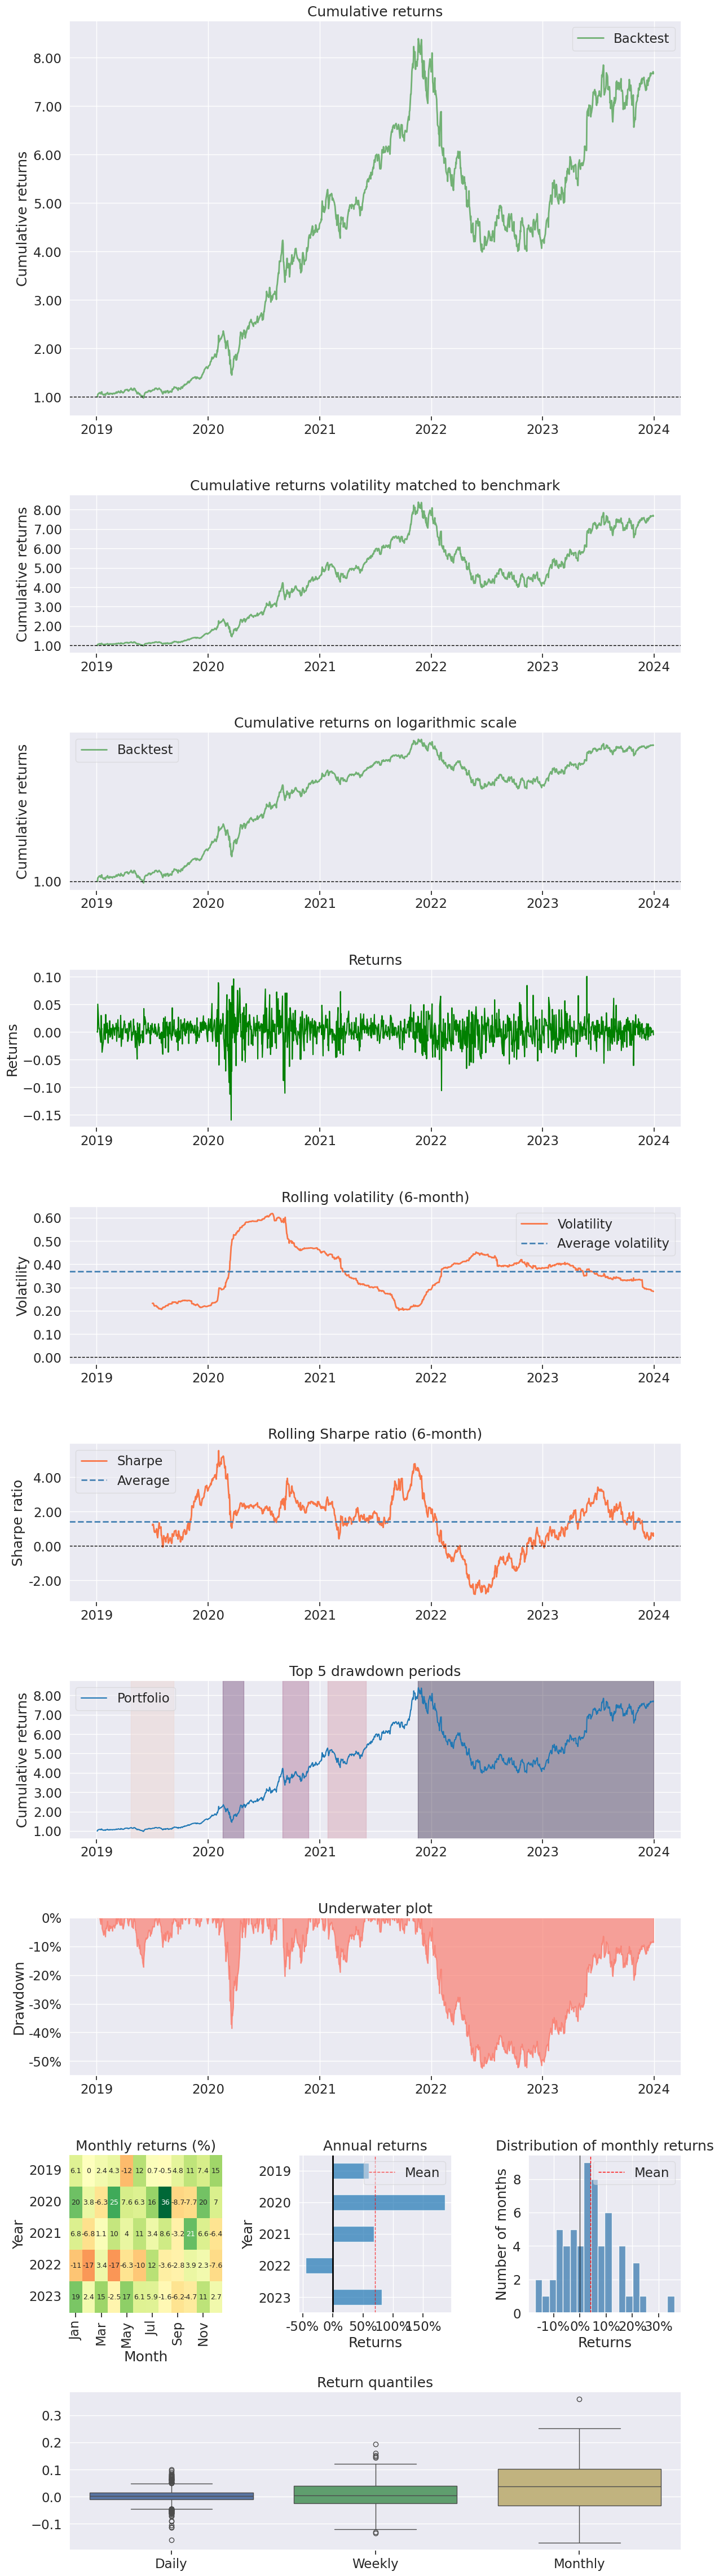

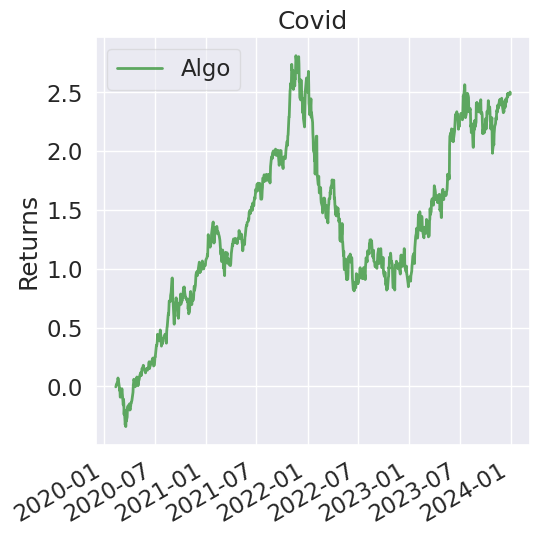

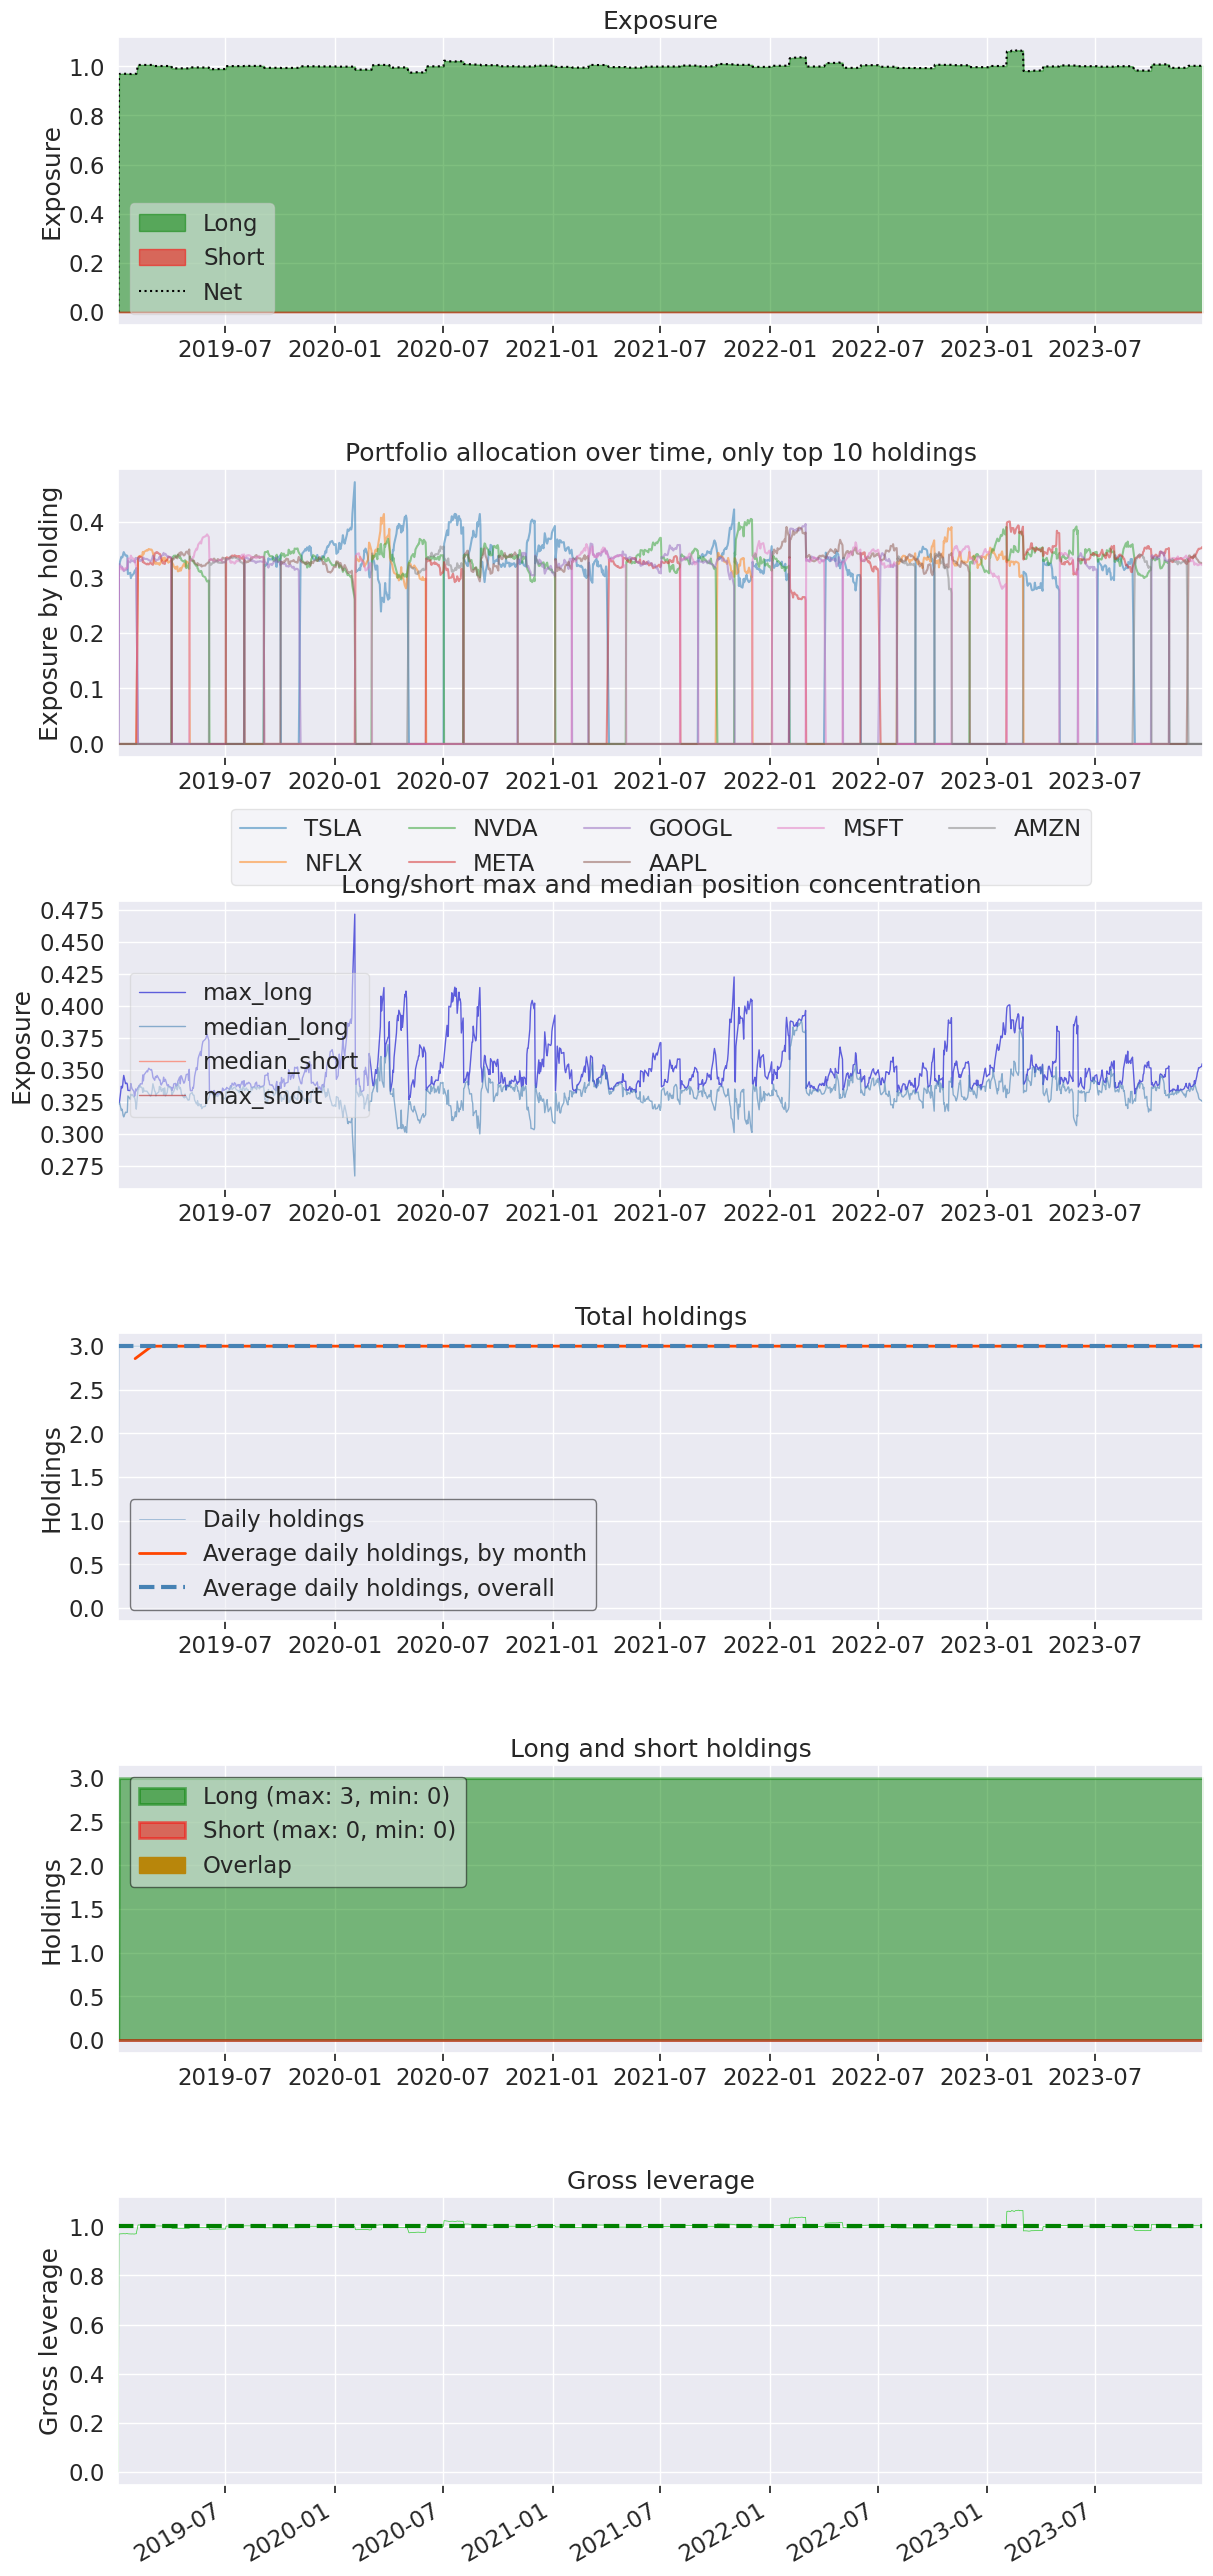

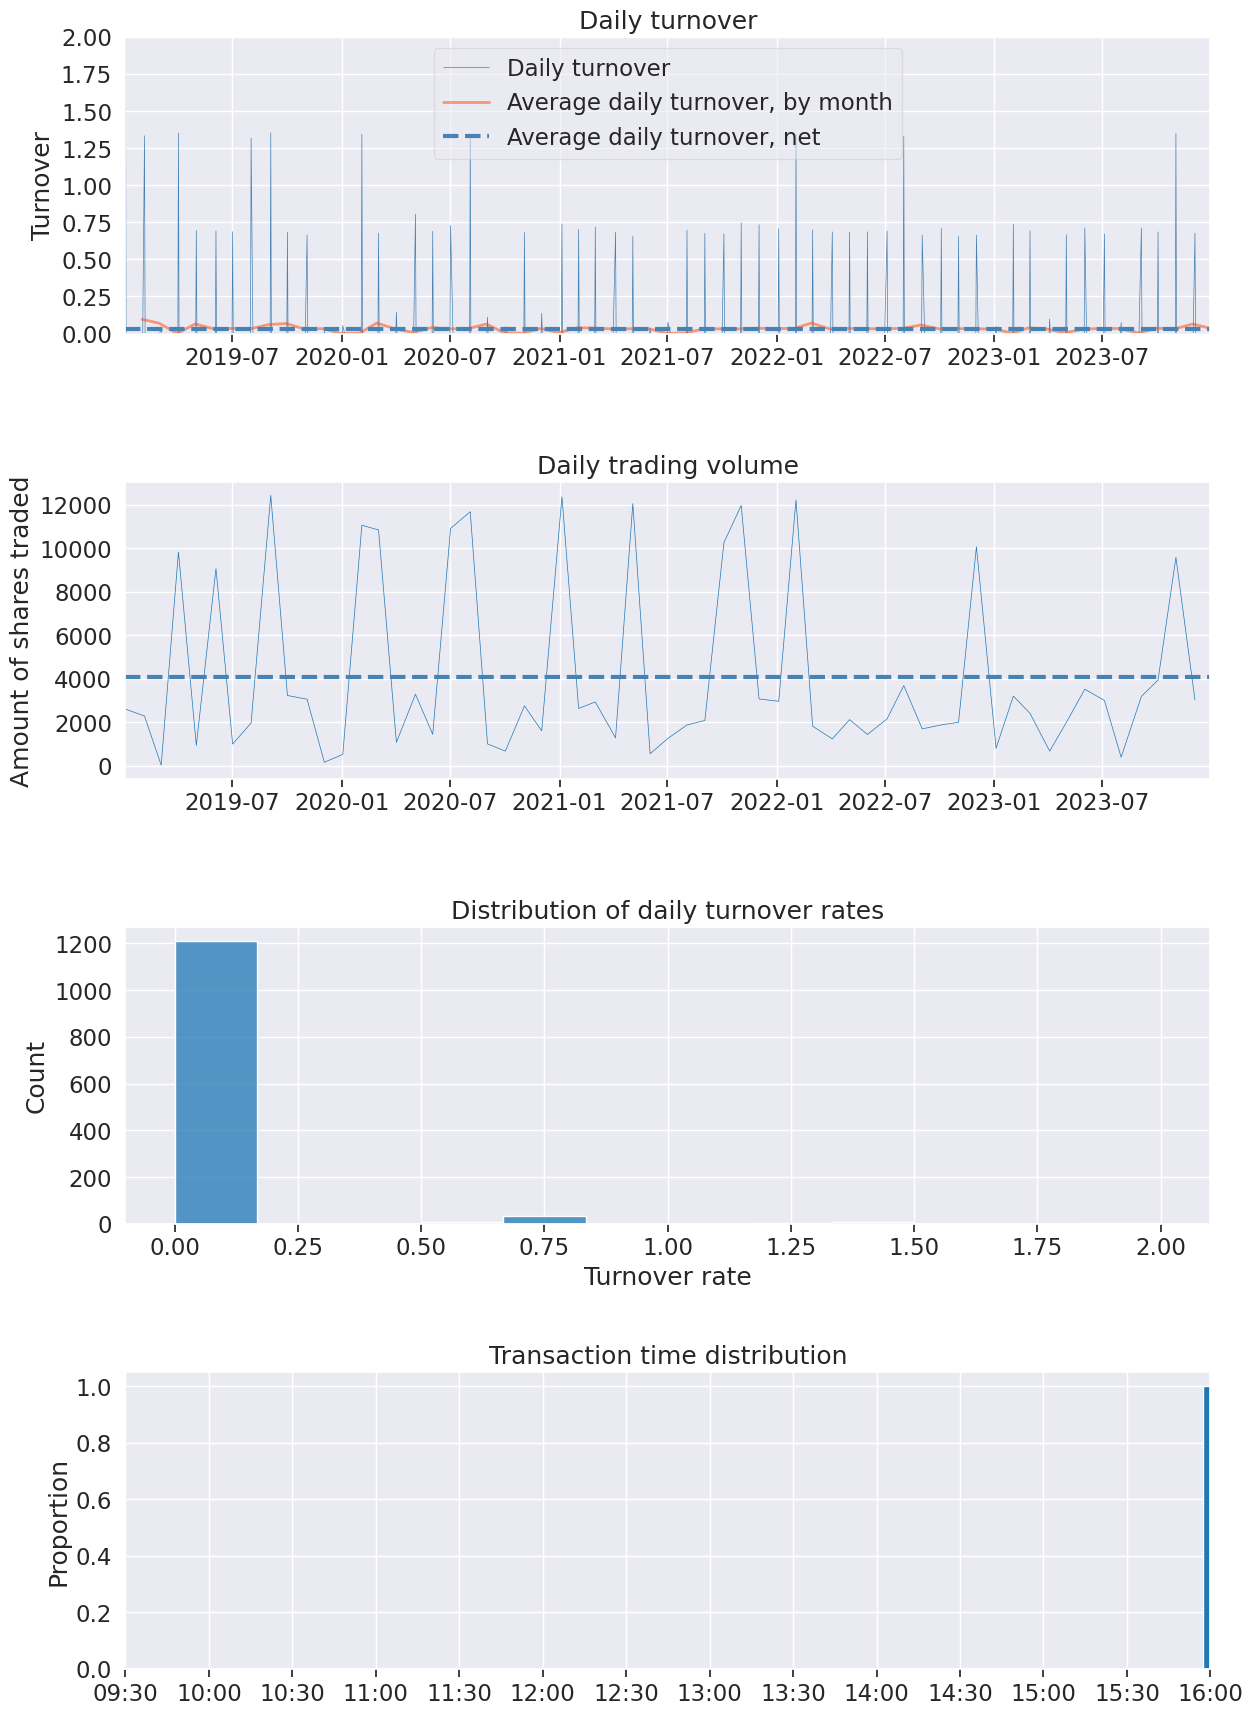

In [6]:
# Create full tearsheet
# Note: Set estimate_intraday=False to avoid issues with transaction format detection
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date=None,     # Set if you have live trading data
    round_trips=False,         # Set to True if you want round-trip analysis
    estimate_intraday=False,   # Disable intraday detection to avoid format issues
)

## Custom Analysis: Key Metrics

In [7]:
# Calculate key metrics manually
annual_return = pf.timeseries.annual_return(returns)
sharpe_ratio = pf.timeseries.sharpe_ratio(returns)
max_drawdown = pf.timeseries.max_drawdown(returns)
sortino_ratio = pf.timeseries.sortino_ratio(returns)
calmar_ratio = pf.timeseries.calmar_ratio(returns)
volatility = pf.timeseries.annual_volatility(returns)

print("\n" + "="*60)
print("KEY PERFORMANCE METRICS")
print("="*60)
print(f"Annual Return: {annual_return*100:.2f}%")
print(f"Annual Volatility: {volatility*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print("="*60)

# Calculate cumulative returns
cum_returns = pf.timeseries.cum_returns(returns)
total_return = cum_returns.iloc[-1]
print(f"\nTotal Return: {total_return*100:.2f}%")
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")


KEY PERFORMANCE METRICS
Annual Return: 50.38%
Annual Volatility: 37.40%
Sharpe Ratio: 1.28
Sortino Ratio: 1.87
Calmar Ratio: 0.96
Max Drawdown: -52.47%

Total Return: 666.63%
Final Portfolio Value: $766,631.56


## Drawdown Analysis

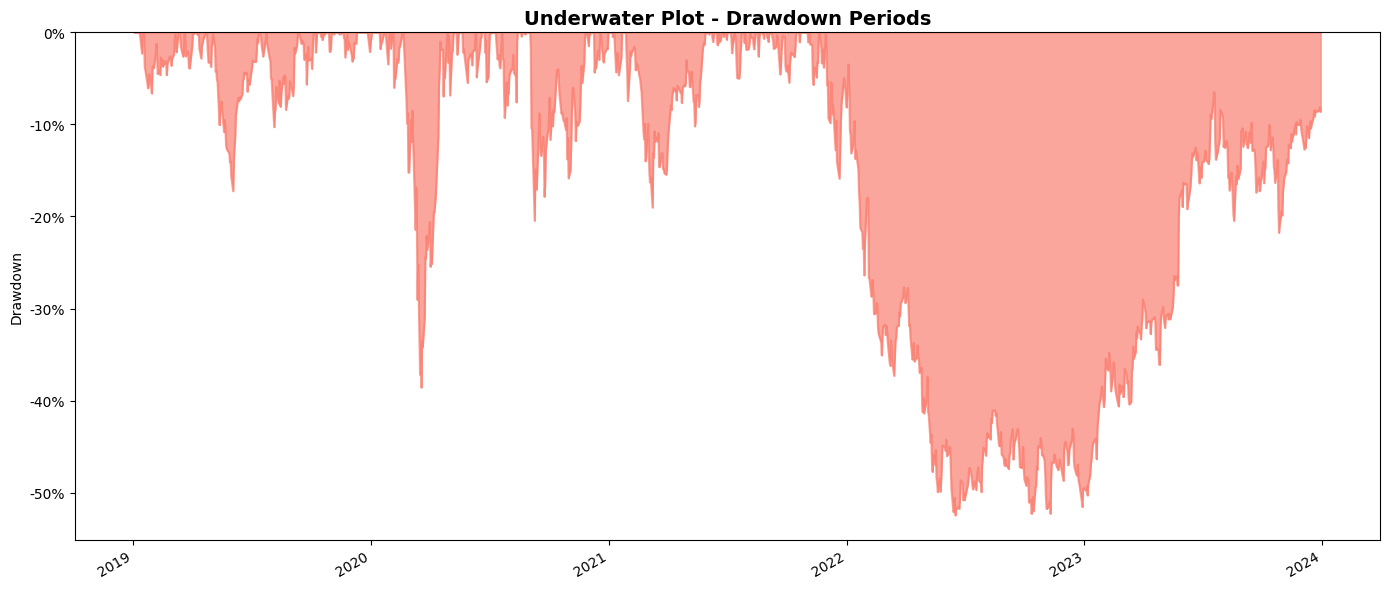


Top 5 Drawdown Periods:
1. Peak: 2021-11-19, Valley: 2022-06-16, Recovery: Not recovered, Drawdown: -52.47%
2. Peak: 2020-02-19, Valley: 2020-03-18, Recovery: 2020-04-27, Drawdown: -38.59%
3. Peak: 2020-09-01, Valley: 2020-09-08, Recovery: 2020-11-25, Drawdown: -20.47%
4. Peak: 2021-01-26, Valley: 2021-03-08, Recovery: 2021-06-01, Drawdown: -19.03%
5. Peak: 2019-04-23, Valley: 2019-06-03, Recovery: 2019-09-11, Drawdown: -17.25%


In [8]:
# Plot drawdowns
fig, ax = plt.subplots(figsize=(14, 6))
pf.plot_drawdown_underwater(returns, ax=ax)
plt.title('Underwater Plot - Drawdown Periods', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Get worst drawdown periods
print("\nTop 5 Drawdown Periods:")
print("="*60)
drawdowns = pf.timeseries.get_top_drawdowns(returns, top=5)

if len(drawdowns) > 0:
    # Calculate drawdown series for looking up values
    cum_returns = pf.timeseries.cum_returns(returns, starting_value=1.0)
    running_max = cum_returns.expanding().max()
    underwater = (cum_returns - running_max) / running_max
    
    for i, dd in enumerate(drawdowns, 1):
        # get_top_drawdowns returns tuples with (peak_date, valley_date, recovery_date)
        peak = pd.Timestamp(dd[0])  # peak_date
        valley = pd.Timestamp(dd[1])  # valley_date
        recovery = pd.Timestamp(dd[2]) if pd.notna(dd[2]) else None  # recovery_date
        
        # Calculate max drawdown for this period
        max_dd = underwater.loc[valley]
        
        recovery_str = recovery.strftime('%Y-%m-%d') if recovery else 'Not recovered'
        
        print(f"{i}. Peak: {peak.strftime('%Y-%m-%d')}, "
              f"Valley: {valley.strftime('%Y-%m-%d')}, "
              f"Recovery: {recovery_str}, "
              f"Drawdown: {max_dd*100:.2f}%")
else:
    print("No significant drawdown periods found.")

## Monthly Returns Heatmap

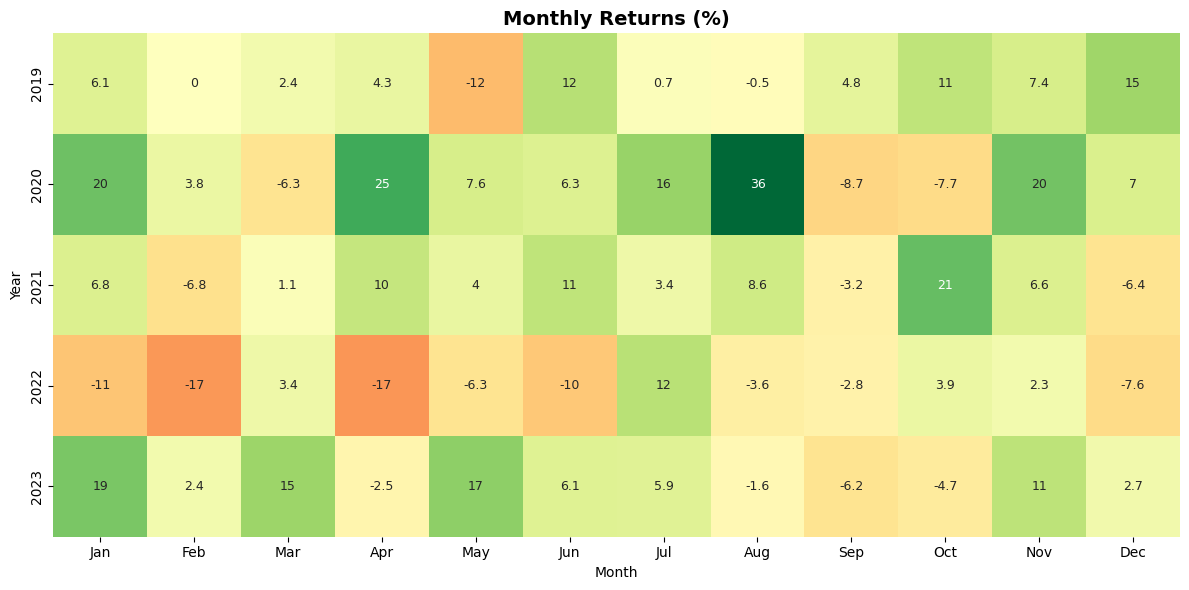

In [9]:
# Monthly returns heatmap
fig, ax = plt.subplots(figsize=(12, 6))
pf.plot_monthly_returns_heatmap(returns, ax=ax)
plt.title('Monthly Returns (%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Rolling Sharpe Ratio

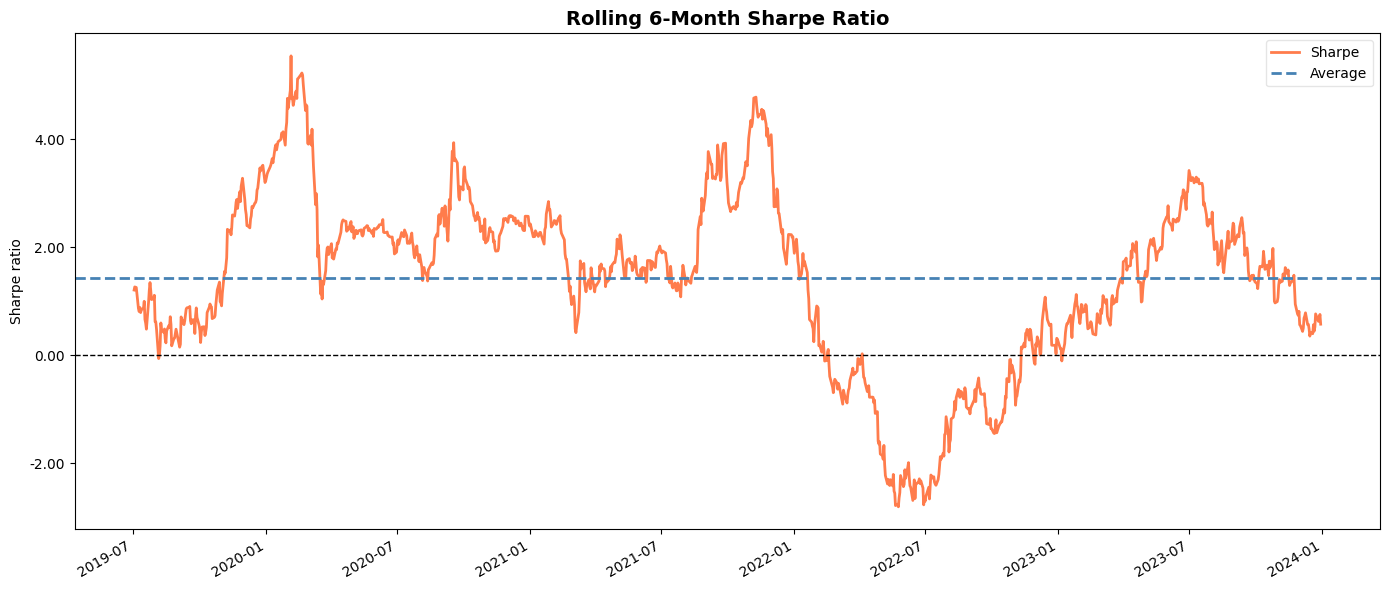

In [10]:
# Plot rolling Sharpe ratio
fig, ax = plt.subplots(figsize=(14, 6))
pf.plot_rolling_sharpe(returns, ax=ax)
plt.title('Rolling 6-Month Sharpe Ratio', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Returns Distribution

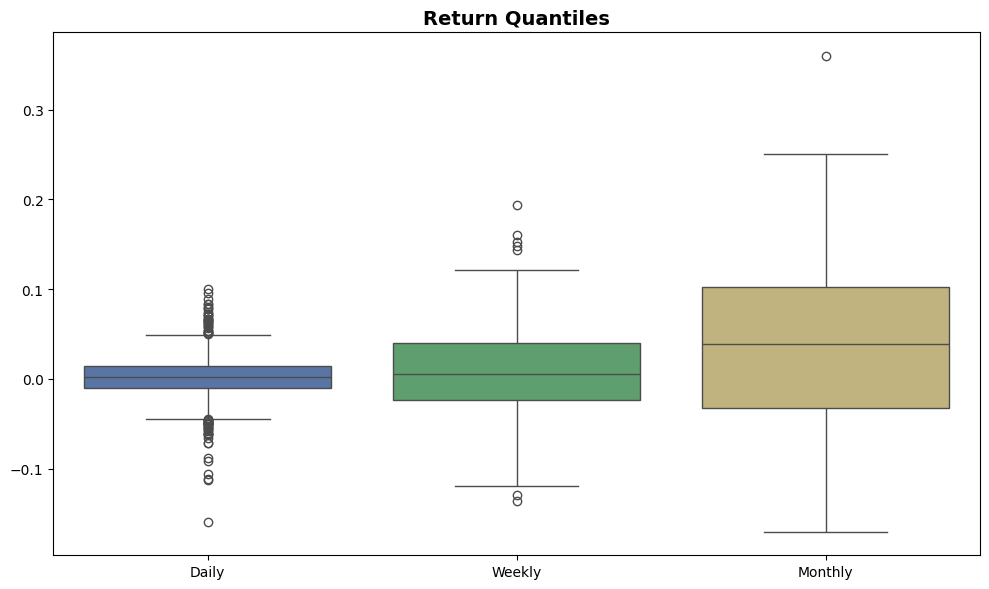

In [11]:
# Plot returns distribution
fig, ax = plt.subplots(figsize=(10, 6))
pf.plot_return_quantiles(returns, ax=ax)
plt.title('Return Quantiles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Compare with Benchmark (SPY)

In [12]:
# Note: For benchmark comparison, you would typically:
# 1. Run a separate backtest with SPY buy-and-hold
# 2. Or fetch SPY returns from data source
# 3. Pass benchmark_rets to create_full_tear_sheet()

# Example structure:
# benchmark_returns = fetch_spy_returns(start_date, end_date)
# pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_returns)

print("\nTo compare with a benchmark:")
print("1. Run a separate buy-and-hold backtest for SPY")
print("2. Extract its returns")
print("3. Pass as benchmark_rets parameter to create_full_tear_sheet()")


To compare with a benchmark:
1. Run a separate buy-and-hold backtest for SPY
2. Extract its returns
3. Pass as benchmark_rets parameter to create_full_tear_sheet()


## Transaction Analysis

In [13]:
# Transaction summary using the already-extracted transactions DataFrame
if transactions is not None and len(transactions) > 0:
    print("\n" + "="*60)
    print("TRANSACTION SUMMARY")
    print("="*60)
    print(f"Total Transactions: {len(transactions)}")
    print(f"Buys: {len(transactions[transactions['amount'] > 0])}")
    print(f"Sells: {len(transactions[transactions['amount'] < 0])}")
    print(f"Total Value Traded: ${transactions['value'].abs().sum():,.2f}")
    print(f"Average Trade Size: ${transactions['value'].abs().mean():,.2f}")
    print("\nMost Traded Symbols:")
    print(transactions['symbol'].value_counts().head(5))
    
    # Show sample transactions
    print("\nSample Transactions:")
    print(transactions.head(10).to_string())
else:
    print("\nNo transactions executed.")


TRANSACTION SUMMARY
Total Transactions: 234
Buys: 108
Sells: 126
Total Value Traded: $16,903,849.95
Average Trade Size: $72,238.67

Most Traded Symbols:
symbol
NVDA     42
TSLA     38
MSFT     31
AAPL     31
GOOGL    30
Name: count, dtype: int64

Sample Transactions:
                          symbol  amount       price         value
2019-01-03 21:00:00+00:00   MSFT     351   91.336646  32059.162571
2019-01-03 21:00:00+00:00  GOOGL     636   50.945460  32401.312560
2019-01-03 21:00:00+00:00   TSLA    1612   20.034012  32294.827344
2019-02-04 21:00:00+00:00   MSFT    -351   99.058446 -34769.514546
2019-02-04 21:00:00+00:00   META     214  168.306111  36017.507754
2019-02-04 21:00:00+00:00   TSLA   -1612   20.848571 -33607.895646
2019-02-04 21:00:00+00:00   NFLX     103  351.515670  36206.114010
2019-03-04 21:00:00+00:00  GOOGL     -10   57.244364   -572.443635
2019-03-04 21:00:00+00:00   META       7  166.436177   1165.053236
2019-03-04 21:00:00+00:00   NFLX      -3  350.864480  -1052.5

## Export Results

Save results for later analysis or reporting.

In [14]:
# Save to CSV
# results.to_csv('backtest_results.csv')
# returns.to_csv('returns.csv')
# if all_txns:
#     txn_df.to_csv('transactions.csv', index=False)

print("\nTo save results, uncomment the lines above.")


To save results, uncomment the lines above.


## Summary

**What we covered:**
- Running a momentum rotation strategy
- Generating pyfolio tearsheets
- Analyzing key performance metrics
- Visualizing drawdowns, returns, and risk
- Transaction analysis

**Key pyfolio functions:**
- `create_full_tear_sheet()` - Complete analysis
- `create_returns_tear_sheet()` - Returns focused
- `create_position_tear_sheet()` - Position analysis
- `create_txn_tear_sheet()` - Transaction costs
- `create_round_trip_tear_sheet()` - Round trip analysis

**Next steps:**
- Try with your own strategies
- Compare multiple strategies side-by-side
- Add benchmark comparisons (SPY, QQQ, etc.)
- Analyze factor exposures (requires additional data)